In [2]:
from pathlib import Path
import re
from collections import Counter
import math

import pandas as pd
import matplotlib.pyplot as plt

# Paths
DATA_DIR = Path("../../data") if Path(".").name != "applied-NLP-project" else Path("data")
RESULTS_DIR = Path("../../results") if Path(".").name != "applied-NLP-project" else Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

BOOKS = {
    "War_and_Peace": DATA_DIR / "War_and_Peace.txt",
    "Anna_Karenina": DATA_DIR / "Anna_Karenina.txt",
}

# Check that the data files are valid (not HTML)
for name, p in BOOKS.items():
    if not p.exists() or p.stat().st_size < 100000:
        raise FileNotFoundError(f"{name} missing or invalid file at {p}. Please re-download.")


In [3]:
def load_text(path: Path) -> str:
    """Read text file safely"""
    return path.read_text(encoding="utf-8", errors="ignore")

def normalize(text: str) -> str:
    """Lowercase, clean punctuation, and keep words only"""
    text = text.lower()
    text = text.replace("—", " ").replace("–", " ").replace("’", "'")
    text = re.sub(r"[^a-z']+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [4]:
BASIC_STOPWORDS = {
    "the","and","to","of","a","i","in","that","was","he","his","it","you","is","for","with",
    "as","on","her","at","be","not","but","had","she","they","him","by","from","this","have",
    "or","my","we","all","so","one","were","me","are","said","an","which","their","there",
    "what","when","then","out","up","would","if","your","has","into","about","could","over",
    "them","no","more","who","do","did","than","been","any","only","very","some","because",
    "its","those","our","down","again","after"
}

def tokenize(text: str):
    return text.split()

def without_stopwords(tokens):
    return [t for t in tokens if t not in BASIC_STOPWORDS and not t.startswith("'") and not t.endswith("'")]


In [5]:
def per_10k(count, total_words):
    return (count / total_words) * 10_000 if total_words else 0.0

corp_tokens, corp_counts, corp_totals = {}, {}, {}

for name, path in BOOKS.items():
    text = load_text(path)
    norm = normalize(text)
    tokens = tokenize(norm)
    clean_tokens = without_stopwords(tokens)

    corp_tokens[name] = clean_tokens
    corp_counts[name] = Counter(clean_tokens)
    corp_totals[name] = len(clean_tokens)

pd.DataFrame({
    "corpus": corp_totals.keys(),
    "tokens_after_cleaning": corp_totals.values()
})


,corpus,tokens_after_cleaning
0,War_and_Peace,299378
1,Anna_Karenina,172121


In [6]:
vocab = set().union(*[set(corp_counts[name].keys()) for name in BOOKS.keys()])

rows = []
for w in vocab:
    row = {"word": w}
    for name in BOOKS.keys():
        c = corp_counts[name][w]
        row[f"{name}_count"] = c
        row[f"{name}_per10k"] = per_10k(c, corp_totals[name])
    rows.append(row)

freq_df = pd.DataFrame(rows)
freq_df.head(10)


,word,War_and_Peace_count,War_and_Peace_per10k,Anna_Karenina_count,Anna_Karenina_per10k
0,wounds,8,0.267221,4,0.232395
1,rinova,5,0.167013,0,0.000000
2,weakened,6,0.200416,1,0.058099
3,inconceivable,5,0.167013,3,0.174296
4,notables,3,0.100208,0,0.000000
5,victims,3,0.100208,0,0.000000
6,refined,11,0.367428,2,0.116197
7,pogatchev's,0,0.000000,1,0.058099
8,grinning,1,0.033403,0,0.000000
9,uneventful,0,0.000000,1,0.058099


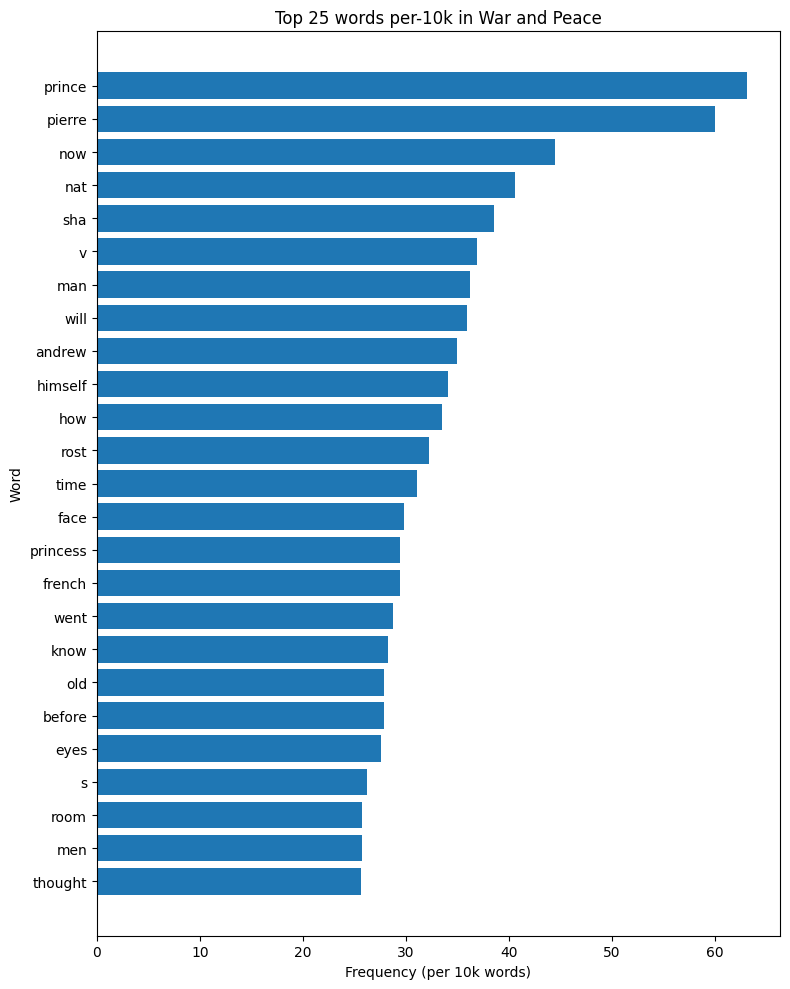

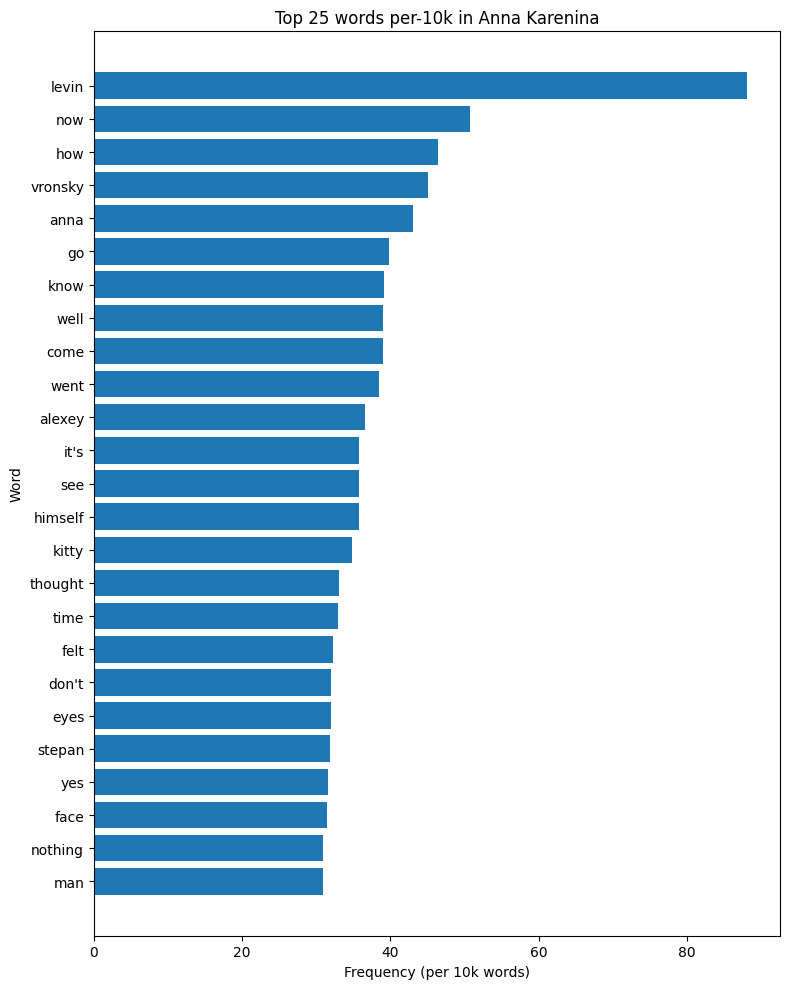

In [7]:
def plot_top_per10k(df, book, k=25):
    top = df.sort_values(f"{book}_per10k", ascending=False).head(k)
    plt.figure(figsize=(8,10))
    plt.barh(top["word"][::-1], top[f"{book}_per10k"][::-1])
    plt.title(f"Top {k} words per-10k in {book.replace('_',' ')}")
    plt.xlabel("Frequency (per 10k words)")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()

plot_top_per10k(freq_df, "War_and_Peace")
plot_top_per10k(freq_df, "Anna_Karenina")


In [8]:
def log_likelihood(k1, n1, k2, n2):
    if k1 == 0 and k2 == 0:
        return 0
    p = (k1 + k2) / (n1 + n2)
    e1, e2 = n1 * p, n2 * p

    def t(o, e): return 0 if o == 0 else o * math.log(o / e)
    g2 = 2 * (t(k1, e1) + t(k2, e2))
    return g2 if (k1/n1 if n1 else 0) >= (k2/n2 if n2 else 0) else -g2

rows = []
for _, r in freq_df.iterrows():
    w = r["word"]
    k1, k2 = r["War_and_Peace_count"], r["Anna_Karenina_count"]
    if k1 + k2 >= 5:
        rows.append({
            "word": w,
            "G2_signed": log_likelihood(k1, corp_totals["War_and_Peace"], k2, corp_totals["Anna_Karenina"]),
            "War_and_Peace_per10k": r["War_and_Peace_per10k"],
            "Anna_Karenina_per10k": r["Anna_Karenina_per10k"]
        })

keyness_df = pd.DataFrame(rows).sort_values("G2_signed", ascending=False)
keyness_df.head(20)


,word,G2_signed,War_and_Peace_per10k,Anna_Karenina_per10k
4706,pierre,1604.350262,59.991048,0.116197
3432,nat,1103.730281,40.584144,0.000000
4370,sha,1047.408242,38.513184,0.000000
3858,v,1002.895663,36.876457,0.000000
7072,andrew,951.115724,34.972510,0.000000
4886,prince,901.531635,63.164294,9.586279
4176,rost,876.625285,32.233497,0.000000
6303,s,611.895730,26.187629,0.697184
2419,nicholas,547.777251,20.141761,0.000000
7652,mary,535.788770,20.542592,0.116197


In [9]:
freq_df.to_csv(RESULTS_DIR / "word_frequencies.csv", index=False)
keyness_df.to_csv(RESULTS_DIR / "distinctive_words.csv", index=False)
print("✅ Results saved in:", RESULTS_DIR)


✅ Results saved in: ..\..\results


In [10]:
print("Top distinctive words for War and Peace:")
print(keyness_df.head(10)[["word", "G2_signed"]])

print("\nTop distinctive words for Anna Karenina:")
print(keyness_df.tail(10)[["word", "G2_signed"]])


Top distinctive words for War and Peace:
          word    G2_signed
4706    pierre  1604.350262
3432       nat  1103.730281
4370       sha  1047.408242
3858         v  1002.895663
7072    andrew   951.115724
4886    prince   901.531635
4176      rost   876.625285
6303         s   611.895730
2419  nicholas   547.777251
7652      mary   535.788770

Top distinctive words for Anna Karenina:
                word    G2_signed
4479           dolly  -564.322787
797       ivanovitch  -570.369103
2643          sergey  -606.646997
1787    arkadyevitch -1029.889087
7109  alexandrovitch -1056.089788
6580          stepan -1106.475751
8082           kitty -1193.363906
3740          alexey -1267.710833
7689         vronsky -1563.980297
7027           levin -3057.420245
